Let's first install the dependencies for this notebook.

In [ ]:
%pip install numpy matplotlib imageio

In [1]:
from typing import Tuple, Set, Dict, List
import numpy as np
from attr import dataclass
import matplotlib.pyplot as plt
import imageio

# Hierarchical clustering

You will implement a simple Hierarchical Agglomerative Clustering (HAC) 
algorithm and then apply it to cluster pixels in images based on their color.

## Introduction

Pixels in images are often expressed as a 3-dimensional array that describes 
the amount of Red, Green, and Blue color in each pixel. The values for each
color are usually expressed in the range [0, 255].

The following code reads and displays the two images we will work with today.
If you hover over the images, you should see the pixel values for each of the 
three channels.

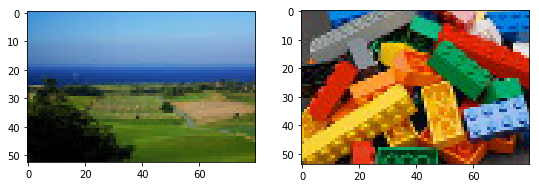

In [35]:
file_names = ["80px-Landscape_seen_from_Ellemandsbjerg.jpg", 
              "80px-Lego_Color_Bricks.jpg"]

fig, ax = plt.subplots(1, 2, figsize=(9, 3))
for idx, f in enumerate(file_names):
    pixels = imageio.imread(f)
    ax[idx].imshow(pixels)
plt.show()

We can cluster pixels based on their color. We can then replace each pixel's 
color with the color of the centroid of the cluster it belongs to. For example,
if a pixel p = [125, 125, 125] is allocated to a cluster whose center is 
c = [150, 145, 145], then we will replace p with the value of c.

## Example

Let's assume we have an image with 20 pixels. It can look like this:

In [3]:
num_pixels = 20
pixel_data = np.random.rand(num_pixels,3) * 255
pixel_data = pixel_data.astype(np.uint8)
print(pixel_data)

print("Size of each element: {} bytes".format(pixel_data.itemsize))
# 20 rows (number of pixels), 3 columns (RGB values per pixel) -> 60 elements in image
size_of_data = pixel_data.size * pixel_data.itemsize
print("Size of data: {} bytes".format(size_of_data))

[[235  26 181]
 [ 30 161  16]
 [219  75  90]
 [ 95 141 109]
 [164  44 100]
 [131 191   1]
 [ 63 103  53]
 [235 218  94]
 [  6 154 100]
 [175 243  25]
 [126 107 143]
 [ 24  13  39]
 [157  83  90]
 [127  46  60]
 [129  75 202]
 [167 198 117]
 [142   2   9]
 [183 243 190]
 [139 111 183]
 [242   8 132]]
Size of each element: 1 bytes
Size of data: 60 bytes


If we were to represent the data using the following 3 cluster centers:

In [40]:
num_clusters = 3
clusters = np.random.rand(num_clusters,3) * 255
clusters = clusters.astype(np.uint8)
print(clusters)

[[135 117  83]
 [171 144  37]
 [202 106 232]]


And cluster assignments:

In [6]:
import random
assignments = np.array([random.randint(0,num_clusters-1) for _ in range(pixel_data.shape[0])])
assignments = assignments.astype(np.uint8)
print(assignments)

[2 1 1 2 2 0 0 1 1 0 0 1 2 0 0 2 1 2 2 1]


We could use a lot less data. More specifically:

In [21]:
def compute_compression(data:np.ndarray, clusters:np.ndarray)->Tuple[float, float]:
    # data.size = 60, since we have 20 pixels with 3 values (RGB) each -> 60 elements in total
    # data.itemsize = 1, since we have one image 
    size_of_data = data.size * data.itemsize
    size_of_compressed_data = data.shape[0] * clusters.itemsize
    size_of_compressed_data += clusters.size * clusters.itemsize
    c = 100.0 - size_of_compressed_data*100 / size_of_data
    return size_of_compressed_data, c

In [22]:
size_of_compressed_data, compression_rate = compute_compression(pixel_data, clusters)
print("Size of compressed data: {} bytes".format(size_of_compressed_data))
print("Compression: {:.2f}%".format(compression_rate))

Size of compressed data: 29 bytes
Compression: 51.67%


Try playing with the number of pixels and number of clusters and see how the compression rate changes.




## Implementing Hierarchical Agglomerative Clustering (HAC)

You will now implement Hierarchical Agglomerative Clustering (HAC) for pixel 
colors. Below is a function signature for the method. 

It should take as input a NumPy array of pixel values like pixel_data above and
a list of cluster sizes for which to report cluster assignment for each point.

For example, if clusters_to_report = [1, 3, 10], then the return value from 
hierarchical_clustering should be a dictionary containing clustering objects
for each of the number of clusters in the list, similar to this:

```python
clusters = {
    1: [0, 0, 0, ..., 0],
    3: [0, 2, 1, ..., 2],
    10: [1, 2, 8, ..., 7],
    }
```

In [131]:
@dataclass(frozen=True)
class Clustering:
    centers: List[np.ndarray]
    assignments: List[int]

In [471]:
def compute_unique_pixels(pixels: np.ndarray, assignments: np.ndarray):
    unique_pixels, unique_pixels_idx, pixel_duplicates = [], [], []
    pixels = list(map(list, pixels))
    for idx, pixel in enumerate(pixels):
        if pixel not in unique_pixels:
            unique_pixels.append(pixel)
            unique_pixels_idx.append(idx)
        else:
            pixel_duplicates.append(pixel)
            unique_idx = unique_pixels.index(pixel)
            orig_idx = unique_pixels_idx[unique_idx]
            assignments[idx] = orig_idx
    assert len(set(assignments)) == len(assignments)-len(pixel_duplicates)
    unique_pixels = np.array(list(map(np.array, unique_pixels)))
    unique_pixels = zip(unique_pixels_idx, unique_pixels)
    return unique_pixels, assignments

In [472]:
def relabel_data_points(pixels, clusters):
    return [np.argmin([np.linalg.norm(px - c) for c in clusters]) for px in pixels]

In [473]:
def hierarchical_clustering(pixel_data: np.ndarray, clusters_to_report: Set[int]) -> Dict[int, Clustering]:
    
    # We start by creating a sample of points to cluster.
    # You might want to reduce the sample size during development of this function. 
    sample_size = 151
    
    # keep original 3D image data (necessary for function that is provided)
    pixel_data_orig = np.copy(pixel_data)
    
    # flatten data from 3D (rows, cols, RGB) into 2D (pixels, RGB)
    pixel_data = pixel_data.reshape((pixel_data.shape[0]*pixel_data.shape[1], 3))
    sample_ids = np.random.choice(list(range(pixel_data.shape[0])), sample_size)
    pixel_data_sample = np.array([pixel_data[e] for e in sample_ids])
    value_to_return = {}
    
    # sort "clusters to report" to better use in while loop
    clusters_to_report = sorted(clusters_to_report, reverse=True)
    
    # at the beginning, each pixel is its own cluster
    assignments = np.array(list(range(sample_size)))
    
    # before running optimization, merge all pixels with same RGB values
    centers, _ = compute_unique_pixels(np.copy(pixel_data_sample), assignments)
    center_indices, center_vals = zip(*centers)
    assert len(center_indices) == len(center_vals) == len(set(assignments))
    
    clustering = True
    
    while clustering:
        # assignments_previous = np.copy(assignments)
        distances = []
        indices = []
        for i, (c1_idx, c1_val) in enumerate(zip(center_indices, center_vals)):
            for j, (c2_idx, c2_val) in enumerate(zip(center_indices, center_vals)):
                # do not compare data points (or clusters) to itself (distance to itself is zero)
                if not np.all(c1_val == c2_val):
                    d = np.linalg.norm(c1_val - c2_val)
                    indices.append((i, j, c1_idx, c2_idx))
                    distances.append(d)
                    
        min_dist_idx = np.argmin(distances)
        c1_cur, c2_cur, _, _ = indices[min_dist_idx]
            
        centroid = np.mean((center_vals[c1_cur], center_vals[c2_cur]), axis=0, dtype=int)

        center_vals = np.delete(center_vals, c1_cur, axis=0)
        center_vals = np.insert(center_vals, c1_cur, centroid, axis=0)

        center_vals = np.delete(center_vals, c2_cur, axis=0)
            
        if len(center_vals) == clusters_to_report[0]:
            assignments = relabel_data_points(pixel_data_sample, center_vals)
            value_to_return[clusters_to_report[0]] = Clustering(centers=center_vals.astype(np.uint8), 
                                                                assignments=assignments)
            clusters_to_report.pop(0)
            
        if len(clusters_to_report) == 0:
            clustering = False
    
    # Since we clustered only the sample, in the following few lines we map each pixel in the full data to
    # the closest cluster.
    for key, value in value_to_return.items():
        pixel_assignments = map_pixels_to_closest_centroid(pixel_data_orig, value.centers)
        new_clustering = Clustering(assignments=pixel_assignments,
                                    centers=value.centers)
        value_to_return[key] = new_clustering
    return value_to_return

Running hierarchical clustering for 80px-Landscape_seen_from_Ellemandsbjerg.jpg
Finished plotting for 80px-Landscape_seen_from_Ellemandsbjerg.jpg and 15
Finished plotting for 80px-Landscape_seen_from_Ellemandsbjerg.jpg and 50
Finished plotting for 80px-Landscape_seen_from_Ellemandsbjerg.jpg and 100
Running hierarchical clustering for 80px-Lego_Color_Bricks.jpg
Finished plotting for 80px-Lego_Color_Bricks.jpg and 15
Finished plotting for 80px-Lego_Color_Bricks.jpg and 50
Finished plotting for 80px-Lego_Color_Bricks.jpg and 100


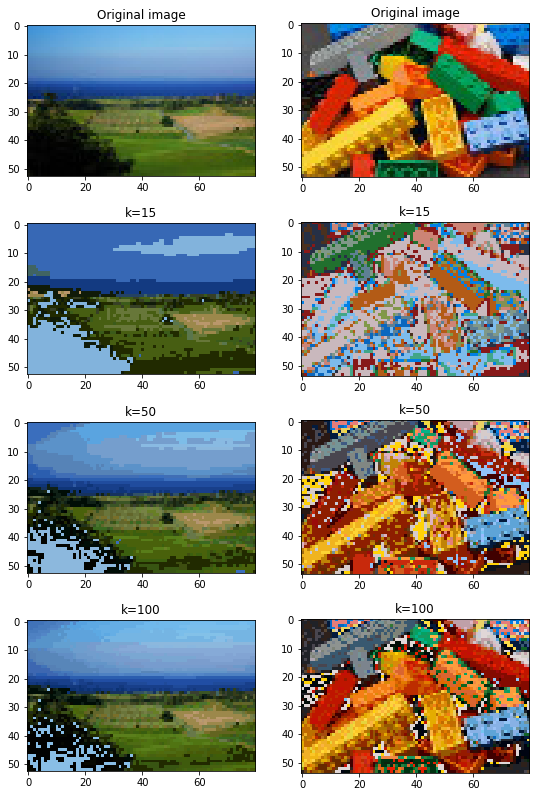

In [474]:
num_clusters = set([15, 50, 100])
plot_compression(num_clusters, hierarchical_clustering)

We will use the clusterings at different granularities to compress the two images.

Below we define a function that generates random cluster assignments. We use 
it to give you an idea of how the clustering works.

In [60]:
def random_clustering(pixel_data: np.ndarray, clusters_to_report: Set[int]) -> Dict[int, Clustering]:
    pixel_data = pixel_data.reshape((pixel_data.shape[0]*pixel_data.shape[1],3))
    v = {}
    num_pixels = pixel_data.shape[0]
    for k in clusters_to_report:
        assignments = [random.randint(0,k-1) for _ in range(num_pixels)]
        centers = np.random.rand(k,3) * 255
        centers = centers.astype(np.uint8)
        v[k] = Clustering(centers=centers, assignments=assignments)
    return v

In [26]:
def replace_pixels(pixel_data:np.ndarray, clustering:Clustering) -> np.ndarray :
    new_pixels = np.array(pixel_data, copy=True)
    new_pixels = new_pixels.reshape((new_pixels.shape[0]*new_pixels.shape[1],3))
    for pixel_id in range(new_pixels.shape[0]):
        cluster_id = clustering.assignments[pixel_id]
        cluster = clustering.centers[cluster_id]
        new_pixels[pixel_id] = np.array(cluster, copy=True)
    new_pixels = new_pixels.reshape((pixel_data.shape[0],pixel_data.shape[1],3))
    return new_pixels

In [27]:
#NOTE: Be aware that this function assumes 3D data (do not use flatten pixel array)
def map_pixels_to_closest_centroid(pixel_data:np.ndarray, centers:np.ndarray)->List[int]:
    def distance (a, b):
        return np.linalg.norm(a - b)
    assignments = []
    for x in range(pixel_data.shape[0]):
        for y in range(pixel_data.shape[1]):
            pixel = pixel_data[x][y]
            min_d = float("inf")
            best_center_id = 0
            for c_id, c in enumerate(centers):
                d = distance(pixel, c)
                if d < min_d:
                    min_d = d
                    best_center_id = c_id
            assignments.append(best_center_id)
    return assignments

In [28]:
def plot_compression(num_clusters, clusterer):
    num_clusters = sorted(num_clusters)
    fig, ax = plt.subplots(len(num_clusters)+1, 2, figsize=(9, 14))
    for idx, f in enumerate(file_names):
        pixels = imageio.imread(f)
        ax[0,idx].imshow(pixels)
        ax[0,idx].set_title("Original image")
        print("Running hierarchical clustering for " + f)
        cluster_assignments = clusterer(pixels, num_clusters)
        if len(cluster_assignments) > 0:
            for i, k in enumerate(num_clusters):
                clustering = cluster_assignments[k]
                new_pixels = replace_pixels(pixels, clustering)
                ax[i+1,idx].imshow(new_pixels)
                ax[i+1,idx].set_title("k={}".format(k))
                print("Finished plotting for {} and {}".format(f, k))
    plt.show()

The following will displayed the images using the random_clustering from above. The images should be just noise since we're not actually clustering anything.

Running hierarchical clustering for 80px-Landscape_seen_from_Ellemandsbjerg.jpg
(15, 3)
(50, 3)
(100, 3)
Finished plotting for 80px-Landscape_seen_from_Ellemandsbjerg.jpg and 15
Finished plotting for 80px-Landscape_seen_from_Ellemandsbjerg.jpg and 50
Finished plotting for 80px-Landscape_seen_from_Ellemandsbjerg.jpg and 100
Running hierarchical clustering for 80px-Lego_Color_Bricks.jpg
(15, 3)
(50, 3)
(100, 3)
Finished plotting for 80px-Lego_Color_Bricks.jpg and 15
Finished plotting for 80px-Lego_Color_Bricks.jpg and 50
Finished plotting for 80px-Lego_Color_Bricks.jpg and 100


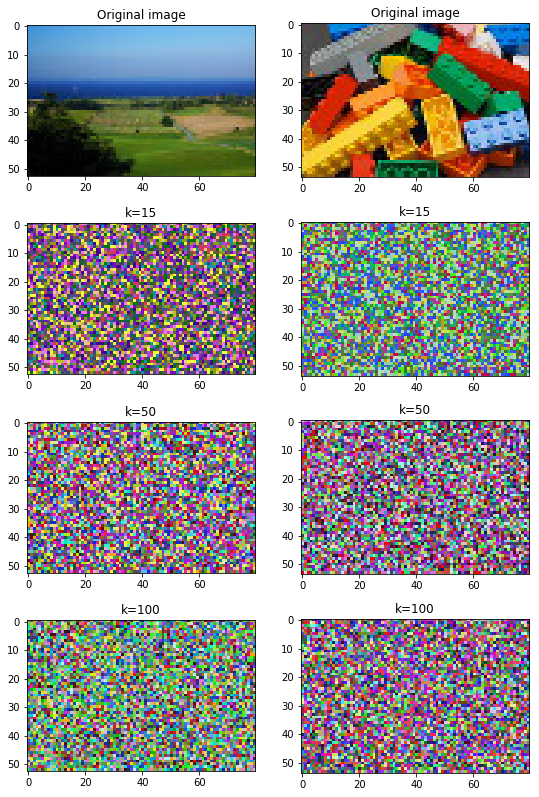

In [61]:
num_clusters = set([15, 50, 100])
plot_compression(num_clusters, random_clustering)

The following will render the images using your hierarchical_clustering function.

Until you implement hierarchical_clustering, only the original images will be displayed.

Running hierarchical clustering for 80px-Landscape_seen_from_Ellemandsbjerg.jpg
Running hierarchical clustering for 80px-Lego_Color_Bricks.jpg


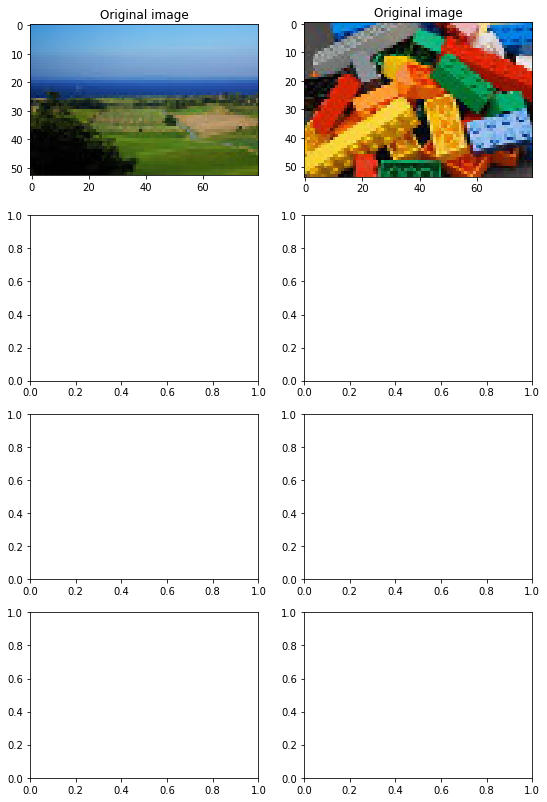

In [16]:
plot_compression(num_clusters, hierarchical_clustering)